# 03 - Scraping Audio Data from Spotify
Spotify maintains a set of audio features for each song, including metrics like loudness, energy, valence, instrumentalness, danceability, etc. These features can be obtained through querying Spotify's API.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import spotipy
import spotipy.util
from spotipy.oauth2 import SpotifyClientCredentials
import os
import pickle as pkl
import re

from importlib import reload
from matplotlib import rcParams

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

% matplotlib inline
% config InlineBackend.figure_format = 'retina'

pd.options.display.max_columns = 999
warnings.filterwarnings('ignore')

UsageError: Line magic function `%` not found.


## Authorization

In [2]:
def get_auth_token(username, client_id, client_secret, redirect_uri):
    try:
        os.remove(f".cache-{username}")
    except:
        None
        
    token = spotipy.util.prompt_for_user_token(
        username, client_id=client_id, client_secret=client_secret,
        redirect_uri=redirect_uri)

    return token

In [3]:
# define data directory where credentials and data (old and new) are stored

credentials = {"client_id": "", "client_secret": "", "username": "", "redirect_uri": "" }


token = get_auth_token(**credentials)

Enter the URL you were redirected to: https://www.google.com/?code=AQDdaOOWa93tZEJbzHZOmZDfMP-eSVTU3_n-jhM6u0gx34Y-rs4lywmjDRxGQNg7kLCEuaZlnndiXJ4c65wocb8ubG0_7GKorAaBqWYY2TNmRTwam7eOobP0RhHSpYixA0NROWDdiFx0GuhTsqg2xfNw8Y-LpQ


## Query Spotify

In [4]:
def query_spotify(songs_df, sp, verbose=False):
    """
    Function queries the spotifyAPI, by using the artist name and the song title
    :param filepath: str | filepath
    :return: pd.DataFrame | dataframe with the audio features from the spotifyAPI
    """
    # search for track + name
    audio_features_df = pd.DataFrame()
    
    failed = []
    for index, row in songs_df.iterrows():
        name = row['song_clean']
        artist = row['artist_clean']
        year = row['year']
        try:
            spotify = spotipy.Spotify(auth=sp)
            results = spotify.search(
                q='track:' + name + ' artist:' + artist, type='track',
                limit=1)
            uri = results['tracks']['items'][0]['uri']
            spotify_song = results['tracks']['items'][0]['name']
            album_name = results['tracks']['items'][0]['album']['name']
            sp_artist = results['tracks']['items'][0]['artists'][0]['name']
            popularity = results['tracks']['items'][0]['popularity']
            release_date = results['tracks']['items'][0]['album']['release_date']
            explicit = results['tracks']['items'][0]['explicit']
            
            if verbose:
                print('successfully queried song {}: {} by {}'.format(index, name, artist))

            audio_feat = spotify.audio_features(uri)
            x = audio_feat[0]
            x.pop('analysis_url')
            x.pop('track_href')
            x['spotify_song'] = spotify_song
            x['spotify_album'] = album_name
            x['spotify_artist'] = sp_artist
            x['billboard_name'] = name
            x['billboard_artist'] = artist
            x['popularity'] = popularity
            x['release_date'] = release_date
            x['explicit'] = explicit
            x['billboard_df_index'] = index
            
            audio_features_df = audio_features_df.append(x, ignore_index=True)
        except:
            if verbose:
                print('failed song {}: {} by {}'.format(index, name, artist, year))
            failed.append([name, artist, year])
            None
            
    failed = pd.DataFrame(failed, columns=['song', 'artist', 'year'])
    return audio_features_df, failed

In [5]:
billboard = pd.read_csv('../data/billboard-lyrics.csv')
billboard.sample(3)

,index,rank,song,artist_base,artist_all,year,artist_featured,song_clean,artist_clean,lyrics,source
1017,17,18,suspicious minds,elvis presley,elvis presley,1969,NaN,suspicious minds,elvis presley,were caught in a trap i cant walk out because...,genius.com
3231,30,31,i've been thinking about you,londonbeat,londonbeat,1991,NaN,ive been thinking about you,londonbeat,we must have been stone crazy when we thought ...,songlyrics.com
4931,30,31,see you again,miley cyrus,miley cyrus,2008,NaN,see you again,miley cyrus,i got my sights set on you and im ready to ai...,genius.com


In [6]:
df2, failed = query_spotify(billboard, token, verbose=True)

successfully queried song 0: the battle of new orleans by johnny horton
successfully queried song 1: mack the knife by bobby darin
successfully queried song 2: personality by lloyd price
successfully queried song 3: venus by frankie avalon
successfully queried song 4: lonely boy by paul anka
successfully queried song 5: dream lover by bobby darin
successfully queried song 6: the three bells by the browns
successfully queried song 7: come softly to me by the fleetwoods
successfully queried song 8: kansas city by wilbert harrison
successfully queried song 9: mr blue by the fleetwoods
successfully queried song 10: sleep walk by santo and johnny
successfully queried song 11: put your head on my shoulder by paul anka
successfully queried song 12: stagger lee by lloyd price
successfully queried song 13: donna by ritchie valens
successfully queried song 14: pink shoe laces by dodie stevens
successfully queried song 15: smoke gets in your eyes by the platters
successfully queried song 16: char

successfully queried song 130: good timin by jimmy jones
successfully queried song 131: beyond the sea by bobby darin
successfully queried song 132: go jimmy go by jimmy clanton
failed song 133: a hrefwikinight_jackie_wilson_song titlenight jackie wilson songnighta by jackie wilson
successfully queried song 134: burning bridges by jack scott
successfully queried song 135: the big hurt by toni fisher
successfully queried song 136: because theyre young by duane eddy
successfully queried song 137: lonely blue boy by conway twitty
successfully queried song 138: pretty blue eyes by steve lawrence
successfully queried song 139: way down yonder in new orleans by freddy cannon
successfully queried song 140: paper roses by anita bryant
successfully queried song 141: mr custer by larry verne
successfully queried song 142: i want to be wanted by brenda lee
successfully queried song 143: mule skinner blues by the fendermen
successfully queried song 144: cradle of love by johnny preston
failed song

successfully queried song 259: one mint julep by ray charles
successfully queried song 260: take good care of her by adam wade
successfully queried song 261: gee whiz look at his eyes by carla thomas
successfully queried song 262: stand by me by ben e king
successfully queried song 263: spanish harlem by ben e king
successfully queried song 264: its gonna work out fine by ike and tina turner
successfully queried song 265: baby blue by the echoes
failed song 266: baby sittin boogie by dion
successfully queried song 267: hats off to larry by del shannon
successfully queried song 268: those oldies but goodies by little caesar and the romans
successfully queried song 269: the fly by chubby checker
successfully queried song 270: maries the name his latest flame by elvis presley
successfully queried song 271: wonderland by night by bert kaempfert
successfully queried song 272: bless you by tony orlando
successfully queried song 273: ive told every little star by linda scott
successfully quer

successfully queried song 387: twist twist senora by gary us bonds
failed song 388: fly me to the moon by jimmy soul
successfully queried song 389: gravy for my mashed potatoes by dee dee sharp
successfully queried song 390: walk on the wild side by jimmy smith
successfully queried song 391: soul twist by king curtis
successfully queried song 392: ill never dance again by bobby rydell
successfully queried song 393: im blue the gong gong song by the ikettes
successfully queried song 394: where have all the flowers gone by the kingston trio
successfully queried song 395: girls girls girls made to love by eddie hodges
successfully queried song 396: town without pity by gene pitney
successfully queried song 397: if i had a hammer by peter paul and mary
successfully queried song 398: i wish that we were married by ronnie and the hi lites
successfully queried song 399: surfin safari by the beach boys
successfully queried song 400: surfin usa by the beach boys
successfully queried song 401: t

successfully queried song 513: love me do by the beatles
successfully queried song 514: do wah diddy diddy by manfred mann
successfully queried song 515: please please me by the beatles
successfully queried song 516: dancing in the street by martha and the vandellas
successfully queried song 517: little children by billy j kramer
failed song 518: love me with all your heart cuando calienta el sol by the ray charles singers
successfully queried song 519: under the boardwalk by the drifters
successfully queried song 520: chapel of love by the dixie cups
successfully queried song 521: suspicion by terry stafford
successfully queried song 522: glad all over by the dave clark five
successfully queried song 523: rag doll by the four seasons
successfully queried song 524: dawn go away by the four seasons
successfully queried song 525: bread and butter by the newbeats
successfully queried song 526: it hurts to be in love by gene pitney
successfully queried song 527: dead mans curve by jan and 

successfully queried song 635: i know a place by petula clark
successfully queried song 636: back in my arms again by the supremes
successfully queried song 637: baby im yours by barbara lewis
successfully queried song 638: the jolly green giant by the kingsmen
successfully queried song 639: hush hush sweet charlotte by patti page
successfully queried song 640: like a rolling stone by bob dylan
successfully queried song 641: im telling you now by freddie and the dreamers
successfully queried song 642: ferry cross the mersey by gerry and the pacemakers
successfully queried song 643: just once in my life by the righteous brothers
failed song 644: the seventh son by johnny rivers
failed song 645: im henry the eighth i am by hermans hermits
successfully queried song 646: a walk in the black forest by horst jankowski
successfully queried song 647: for your love by the yardbirds
successfully queried song 648: california girls by the beach boys
successfully queried song 649: go now by the moo

successfully queried song 758: no matter what shape your stomachs in by the t bones
successfully queried song 759: barefootin by robert parker
successfully queried song 760: just like me by paul revere and the raiders
successfully queried song 761: love makes the world go round by deon jackson
successfully queried song 762: the pied piper by crispian st peters
successfully queried song 763: somewhere my love by ray conniff singers
successfully queried song 764: almost persuaded by david houston
successfully queried song 765: if i were a carpenter by bobby darin
successfully queried song 766: dont mess with bill by the marvelettes
successfully queried song 767: cherry cherry by neil diamond
successfully queried song 768: message to michael by dionne warwick
successfully queried song 769: love is a hurtin thing by lou rawls
successfully queried song 770: gloria by the shadows of knight
successfully queried song 771: my world is empty without you by the supremes
successfully queried song 

successfully queried song 881: bernadette by four tops
successfully queried song 882: the beat goes on by sonny and cher
successfully queried song 883: snoopy vs the red baron by the royal guardsmen
successfully queried song 884: societys child by janis ian
successfully queried song 885: girl youll be a woman soon by neil diamond
successfully queried song 886: aint no mountain high enough by marvin gaye
successfully queried song 887: i take it back by sandy posey
successfully queried song 888: here comes my baby by the tremeloes
successfully queried song 889: everlasting love by robert knight
successfully queried song 890: i dig rock and roll music by peter paul and mary
failed song 891: little ole man uptight everythings alright by bill cosby
successfully queried song 892: i had too much to dream last night by the electric prunes
successfully queried song 893: daydream believer by the monkees
successfully queried song 894: baby i need your lovin by johnny rivers
successfully queried s

successfully queried song 1002: i cant get next to you by the temptations
successfully queried song 1003: honky tonk women by the rolling stones
successfully queried song 1004: everyday people by sly and the family stone
successfully queried song 1005: dizzy by tommy roe
successfully queried song 1006: hot fun in the summertime by sly and the family stone
successfully queried song 1007: ill never fall in love again by tom jones
successfully queried song 1008: build me up buttercup by the foundations
successfully queried song 1009: crimson and clover by tommy james and the shondells
successfully queried song 1010: one by three dog night
successfully queried song 1011: crystal blue persuasion by tommy james and the shondells
successfully queried song 1012: hair by the cowsills
successfully queried song 1013: too busy thinking about my baby by marvin gaye
successfully queried song 1014: love theme from romeo and juliet by henry mancini
successfully queried song 1015: get together by the y

successfully queried song 1123: lay down candles in the rain by melanie safka
successfully queried song 1124: ball of confusion thats what the world is today by the temptations
successfully queried song 1125: love on a two way street by ray goodman and brown
successfully queried song 1126: which way you goin billy by the poppy family
successfully queried song 1127: all right now by free
successfully queried song 1128: i want you back by the jackson 5
successfully queried song 1129: julie do ya love me by bobby sherman
successfully queried song 1130: green eyed lady by sugarloaf
successfully queried song 1131: signed sealed delivered im yours by stevie wonder
successfully queried song 1132: ride captain ride by blues image
successfully queried song 1133: venus by shocking blue
successfully queried song 1134: instant karma by john lennon
successfully queried song 1135: patches by clarence carter
successfully queried song 1136: lookin out my back door by creedence clearwater revival
succe

successfully queried song 1242: dont pull your love by hamilton joe frank and reynolds
successfully queried song 1243: it dont come easy by ringo starr
successfully queried song 1244: mr bojangles by nitty gritty dirt band
successfully queried song 1245: i love you for all seasons by the fuzz
successfully queried song 1246: whatcha see is whatcha get by the dramatics
successfully queried song 1247: thats the way ive always heard it should be by carly simon
successfully queried song 1248: if you really love me by stevie wonder
successfully queried song 1249: spanish harlem by aretha franklin
successfully queried song 1250: i dont know how to love him by helen reddy
successfully queried song 1251: yo yo by the osmonds
successfully queried song 1252: bridge over troubled water by aretha franklin
successfully queried song 1253: doesnt somebody want to be wanted by the partridge family
successfully queried song 1254: draggin the line by tommy james
successfully queried song 1255: proud mary

successfully queried song 1364: sylvias mother by dr hook and the medicine show
successfully queried song 1365: starman by david bowie
successfully queried song 1366: coconut by harry nilsson
successfully queried song 1367: puppy love by donny osmond
successfully queried song 1368: you dont mess around with jim by jim croce
successfully queried song 1369: hot rod lincoln by commander cody and his lost planet airmen
successfully queried song 1370: a cowboys work is never done by sonny and cher
failed song 1371: do you want to dance by apollo 100
successfully queried song 1372: anticipation by carly simon
successfully queried song 1373: never been to spain by three dog night
successfully queried song 1374: kiss an angel good mornin by charley pride
successfully queried song 1375: schools out by alice cooper
successfully queried song 1376: saturday in the park by chicago
successfully queried song 1377: drowning in the sea of love by joe simon
successfully queried song 1378: use me by bill

successfully queried song 1483: funny face by donna fargo
successfully queried song 1484: funky worm by ohio players
successfully queried song 1485: angie by the rolling stones
failed song 1486: jambalaya on the bayou by john fogerty
successfully queried song 1487: dont expect me to be your friend by lobo
successfully queried song 1488: break up to make up by the stylistics
successfully queried song 1489: daisy a day by jud strunk
failed song 1490: also sprach zarathustra 2001 by eumir deodato
successfully queried song 1491: stir it up by johnny nash
successfully queried song 1492: money by pink floyd
successfully queried song 1493: gypsy man by war
successfully queried song 1494: the world is a ghetto by war
successfully queried song 1495: yes we can can by the pointer sisters
successfully queried song 1496: free ride by edgar winter
successfully queried song 1497: space oddity by david bowie
successfully queried song 1498: it never rains in southern california by albert hammond
succe

successfully queried song 1606: some kind of wonderful by grand funk railroad
successfully queried song 1607: shining star by earth wind and fire
successfully queried song 1608: fame by david bowie
successfully queried song 1609: laughter in the rain by neil sedaka
successfully queried song 1610: one of these nights by eagles
successfully queried song 1611: thank god im a country boy by john denver
successfully queried song 1612: jive talkin by bee gees
successfully queried song 1613: best of my love by eagles
successfully queried song 1614: lovin you by minnie riperton
successfully queried song 1615: kung fu fighting by carl douglas
successfully queried song 1616: black water by the doobie brothers
successfully queried song 1617: the ballroom blitz by the sweet
failed song 1618: hey wont you play another somebody done somebody wrong song by bj thomas
successfully queried song 1619: he dont love you like i love you by tony orlando and dawn
successfully queried song 1620: at seventeen b

successfully queried song 1729: theme from  by rhythm heritage
successfully queried song 1730: love rollercoaster by ohio players
successfully queried song 1731: you should be dancing by bee gees
successfully queried song 1732: youll never find another love like mine by lou rawls
successfully queried song 1733: golden years by david bowie
successfully queried song 1734: moonlight feels right by starbuck
successfully queried song 1735: only sixteen by dr hook
successfully queried song 1736: let your love flow by the bellamy brothers
successfully queried song 1737: dream weaver by gary wright
successfully queried song 1738: turn the beat around by vicki sue robinson
successfully queried song 1739: lonely night angel face by captain and tennille
successfully queried song 1740: all by myself by eric carmen
successfully queried song 1741: love to love you baby by donna summer
successfully queried song 1742: deep purple by donny osmond
successfully queried song 1743: theme from  by diana ros

successfully queried song 1855: night moves by bob seger
successfully queried song 1856: youre my world by helen reddy
successfully queried song 1857: heard it in a love song by the marshall tucker band
successfully queried song 1858: carry on wayward son by kansas
successfully queried song 1859: new kid in town by eagles
successfully queried song 1860: my heart belongs to me by barbra streisand
successfully queried song 1861: after the lovin by engelbert humperdinck
successfully queried song 1862: jet airliner by steve miller band
successfully queried song 1863: stand tall by burton cummings
successfully queried song 1864: way down by elvis presley
successfully queried song 1865: weekend in new england by barry manilow
successfully queried song 1866: it was almost like a song by ronnie milsap
successfully queried song 1867: smoke from a distant fire by sanford townsend band
successfully queried song 1868: cold as ice by foreigner
successfully queried song 1869: ariel by dean friedman


successfully queried song 1982: running on empty by jackson browne
successfully queried song 1983: whenever i call you friend by kenny loggins
successfully queried song 1984: fool if you think its over by chris rea
successfully queried song 1985: get off by foxy
successfully queried song 1986: sweet talkin woman by electric light orchestra
successfully queried song 1987: lifes been good by joe walsh
successfully queried song 1988: i love the nightlife by alicia bridges
successfully queried song 1989: you cant turn me off in the middle of turning me on by high inergy
successfully queried song 1990: its so easy by linda ronstadt
successfully queried song 1991: native new yorker by odyssey
successfully queried song 1992: flash light by parliament
successfully queried song 1993: dont look back by boston
successfully queried song 1994: turn to stone by electric light orchestra
successfully queried song 1995: i cant stand the rain by eruption
successfully queried song 1996: ebony eyes by bob

successfully queried song 2107: coming up by paul mccartney
successfully queried song 2108: funkytown by lipps inc
successfully queried song 2109: its still rock and roll to me by billy joel
successfully queried song 2110: the rose by bette midler
successfully queried song 2111: escape the pina colada song by rupert holmes
successfully queried song 2112: cars by gary numan
successfully queried song 2113: cruisin by smokey robinson
successfully queried song 2114: working my way back to you by the spinners
successfully queried song 2115: lost in love by air supply
successfully queried song 2116: little jeannie by elton john
successfully queried song 2117: ride like the wind by christopher cross
successfully queried song 2118: upside down by diana ross
successfully queried song 2119: please dont go by kc and the sunshine band
successfully queried song 2120: babe by styx
successfully queried song 2121: with you im born again by billy preston
successfully queried song 2122: shining star by 

successfully queried song 2235: woman in love by barbra streisand
successfully queried song 2236: the boy from new york city by the manhattan transfer
successfully queried song 2237: urgent by foreigner
successfully queried song 2238: passion by rod stewart
successfully queried song 2239: lady you bring me up by commodores
successfully queried song 2240: crying by don mclean
successfully queried song 2241: hearts by marty balin
successfully queried song 2242: its my turn by diana ross
successfully queried song 2243: you make my dreams by hall and oates
successfully queried song 2244: i dont need you by kenny rogers
successfully queried song 2245: how bout us by champaign
successfully queried song 2246: hit me with your best shot by pat benatar
successfully queried song 2247: the breakup song they dont write em by the greg kihn band
successfully queried song 2248: time by the alan parsons project
successfully queried song 2249: hungry heart by bruce springsteen
failed song 2250: sweethe

successfully queried song 2360: personally by karla bonoff
successfully queried song 2361: one hundred ways by quincy jones
successfully queried song 2362: blue eyes by elton john
successfully queried song 2363: our lips are sealed by the go gos
successfully queried song 2364: you could have been with me by sheena easton
successfully queried song 2365: you can do magic by america
successfully queried song 2366: did it in a minute by hall and oates
successfully queried song 2367: i ran so far away by a flock of seagulls
successfully queried song 2368: somebodys baby by jackson browne
successfully queried song 2369: oh no by commodores
successfully queried song 2370: take it away by paul mccartney
successfully queried song 2371: its gonna take a miracle by deniece williams
successfully queried song 2372: love will turn you around by kenny rogers
successfully queried song 2373: dont stop believin by journey
successfully queried song 2374: comin in and out of your life by barbra streisand


successfully queried song 2486: dead giveaway by shalamar
successfully queried song 2487: lawyers in love by jackson browne
successfully queried song 2488: what about me by moving pictures
successfully queried song 2489: human nature by michael jackson
successfully queried song 2490: photograph by def leppard
successfully queried song 2491: pass the dutchie by musical youth
successfully queried song 2492: true by spandau ballet
successfully queried song 2493: far from over by frank stallone
successfully queried song 2494: ive got a rock n roll heart by eric clapton
successfully queried song 2495: it might be you by stephen bishop
successfully queried song 2496: tonight i celebrate my love by peabo bryson
successfully queried song 2497: you got lucky by tom petty and the heartbreakers
successfully queried song 2498: dont cry by asia
successfully queried song 2499: breaking us in two by joe jackson
successfully queried song 2500: fall in love with me by earth wind and fire
successfully q

successfully queried song 2612: easy lover by philip bailey
successfully queried song 2613: cant fight this feeling by reo speedwagon
successfully queried song 2614: we built this city by starship
successfully queried song 2615: the power of love by huey lewis and the news
successfully queried song 2616: dont you forget about me by simple minds
successfully queried song 2617: cherish by kool and the gang
successfully queried song 2618: st elmos fire man in motion by john parr
successfully queried song 2619: the heat is on by glenn frey
successfully queried song 2620: we are the world by usa for africa
successfully queried song 2621: shout by tears for fears
successfully queried song 2622: part time lover by stevie wonder
successfully queried song 2623: saving all my love for you by whitney houston
successfully queried song 2624: heaven by bryan adams
successfully queried song 2625: everything she wants by wham
successfully queried song 2626: cool it now by new edition
successfully quer

successfully queried song 2742: danger zone by kenny loggins
successfully queried song 2743: what have you done for me lately by janet jackson
successfully queried song 2744: no one is to blame by howard jones
successfully queried song 2745: lets go all the way by sly fox
successfully queried song 2746: i didnt mean to turn you on by robert palmer
successfully queried song 2747: words get in the way by gloria estefan
successfully queried song 2748: manic monday by the bangles
successfully queried song 2749: walk of life by dire straits
successfully queried song 2750: amanda by boston
successfully queried song 2751: two of hearts by stacey q
successfully queried song 2752: crush on you by the jets
successfully queried song 2753: if you leave by orchestral manoeuvres in the dark
successfully queried song 2754: invisible touch by genesis
successfully queried song 2755: the sweetest taboo by sade
successfully queried song 2756: what you need by inxs
successfully queried song 2757: talk to 

successfully queried song 2873: rock steady by the whispers
successfully queried song 2874: wanted dead or alive by bon jovi
successfully queried song 2875: big time by peter gabriel
successfully queried song 2876: the finer things by steve winwood
successfully queried song 2877: let me be the one by expose
successfully queried song 2878: is this love by survivor
successfully queried song 2879: diamonds by herb alpert
successfully queried song 2880: point of no return by expose
successfully queried song 2881: big love by fleetwood mac
successfully queried song 2882: midnight blue by lou gramm
successfully queried song 2883: something so strong by crowded house
successfully queried song 2884: heat of the night by bryan adams
successfully queried song 2885: nothings gonna change my love for you by glenn medeiros
successfully queried song 2886: brilliant disguise by bruce springsteen
successfully queried song 2887: just to see her by smokey robinson
successfully queried song 2888: who wil

successfully queried song 3000: prove your love by taylor dayne
successfully queried song 3001: look away by chicago
successfully queried song 3002: my prerogative by bobby brown
successfully queried song 3003: every rose has its thorn by poison
successfully queried song 3004: straight up by paula abdul
successfully queried song 3005: miss you much by janet jackson
successfully queried song 3006: cold hearted by paula abdul
successfully queried song 3007: wind beneath my wings by bette midler
successfully queried song 3008: girl you know its true by milli vanilli
failed song 3009: baby i love your wayfreebird medley by will to power
successfully queried song 3010: giving you the best that i got by anita baker
successfully queried song 3011: right here waiting by richard marx
successfully queried song 3012: waiting for a star to fall by boy meets girl
successfully queried song 3013: lost in your eyes by debbie gibson
successfully queried song 3014: dont wanna lose you by gloria estefan


successfully queried song 3129: dont wanna fall in love by jane child
successfully queried song 3130: two to make it right by seduction
successfully queried song 3131: sending all my love by linear
successfully queried song 3132: unskinny bop by poison
successfully queried song 3133: step by step by new kids on the block
successfully queried song 3134: dangerous by roxette
successfully queried song 3135: we didnt start the fire by billy joel
successfully queried song 3136: i dont have the heart by james ingram
successfully queried song 3137: downtown train by rod stewart
successfully queried song 3138: rhythm nation by janet jackson
successfully queried song 3139: ill be your everything by tommy page
successfully queried song 3140: roam by the b 52s
successfully queried song 3141: everything by jody watley
successfully queried song 3142: back to life however do you want me by soul ii soul
successfully queried song 3143: here and now by luther vandross
successfully queried song 3144: al

successfully queried song 3258: temptation by corina
successfully queried song 3259: cant stop this thing we started by bryan adams
successfully queried song 3260: i cant wait another minute by hi five
successfully queried song 3261: 3 am eternal by the klf
successfully queried song 3262: time love and tenderness by michael bolton
successfully queried song 3263: sadeness part i by enigma
successfully queried song 3264: around the way girl by ll cool j
successfully queried song 3265: ill be there by the escape club
successfully queried song 3266: cream by prince
successfully queried song 3267: now that we found love by heavy d
successfully queried song 3268: show me the way by styx
successfully queried song 3269: love takes time by mariah carey
successfully queried song 3270: cry for help by rick astley
successfully queried song 3271: the way you do the things you do by ub40
successfully queried song 3272: here i am come and take me by ub40
successfully queried song 3273: signs by tesla

successfully queried song 3388: what about your friends by tlc
successfully queried song 3389: thinkin back by color me badd
successfully queried song 3390: would i lie to you by charles and eddie
successfully queried song 3391: thats what love is for by amy grant
successfully queried song 3392: keep coming back by richard marx
successfully queried song 3393: free your mind by en vogue
successfully queried song 3394: keep it comin by keith sweat
successfully queried song 3395: just take my heart by mr big
successfully queried song 3396: i will remember you by amy grant
successfully queried song 3397: we got a love thang by cece peniston
successfully queried song 3398: lets get rocked by def leppard
successfully queried song 3399: they want efx by das efx
successfully queried song 3400: i cant make you love me by bonnie raitt
successfully queried song 3401: i will always love you by whitney houston
successfully queried song 3402: whoomp there it is by tag team
successfully queried song 

successfully queried song 3522: regulate by warren g
successfully queried song 3523: if you go by jon secada
successfully queried song 3524: back  forth by aaliyah
successfully queried song 3525: now and forever by richard marx
successfully queried song 3526: when can i see you by babyface
successfully queried song 3527: please forgive me by bryan adams
successfully queried song 3528: so much in love by all 4 one
successfully queried song 3529: shoop by salt n pepa
successfully queried song 3530: any time any place by janet jackson
failed song 3531: shine by vanessa williams
failed song 3532: said i loved youbut i lied by michael bolton
successfully queried song 3533: return to innocence by enigma
successfully queried song 3534: all i wanna do by sheryl crow
successfully queried song 3535: mmm mmm mmm mmm by crash test dummies
successfully queried song 3536: can we talk by tevin campbell
failed song 3537: funkdafied by brandy
successfully queried song 3538: id do anything for love but 

successfully queried song 3659: believe by elton john
successfully queried song 3660: carnival by natalie merchant
successfully queried song 3661: you dont know how it feels by tom petty
successfully queried song 3662: back for good by take that
successfully queried song 3663: tootsee roll by 69 boyz
successfully queried song 3664: you want this by janet jackson
successfully queried song 3665: tell me by groove theory
successfully queried song 3666: cant you see by total
successfully queried song 3667: all i wanna do by sheryl crow
failed song 3668: this lil game we play by subway
successfully queried song 3669: come and get your love by real mccoy
successfully queried song 3670: this aint a love song by bon jovi
successfully queried song 3671: secret by madonna
successfully queried song 3672: players anthem by junior mafia
successfully queried song 3673: feel me flow by naughty by nature
successfully queried song 3674: every day of the week by jade
successfully queried song 3675: the 

successfully queried song 3794: beautiful life by ace of base
successfully queried song 3795: back for good by take that
successfully queried song 3796: i got id by pearl jam
successfully queried song 3797: soon as i get home by faith evans
successfully queried song 3798: macarena by los del rio
successfully queried song 3799: only wanna be with you by hootie and the blowfish
successfully queried song 3800: dont cry by seal
successfully queried song 3801: something about the way you look tonight by elton john
failed song 3802: foolish games by brandy
failed song 3803: ill be missing you by sean combs
successfully queried song 3804: un break my heart by toni braxton
failed song 3805: cant nobody hold me down by sean combs
successfully queried song 3806: i believe i can fly by r kelly
successfully queried song 3807: dont let go love by en vogue
successfully queried song 3808: return of the mack by mark morrison
successfully queried song 3809: how do i live by leann rimes
successfully que

successfully queried song 3928: sex and candy by marcy playground
successfully queried song 3929: show me love by robyn
successfully queried song 3930: a song for mama by boyz ii men
successfully queried song 3931: what you want by mase
successfully queried song 3932: frozen by madonna
successfully queried song 3933: gone till november by wyclef jean
successfully queried song 3934: my body by lsg
successfully queried song 3935: tubthumping by chumbawamba
successfully queried song 3936: deja vu uptown baby by lord tariq and peter gunz
successfully queried song 3937: i want you back by n sync
successfully queried song 3938: when the lights go out by five
successfully queried song 3939: they dont know by jon b
successfully queried song 3940: make em say uhh by master p
failed song 3941: make it hot by nicole wray
successfully queried song 3942: never ever by all saints
failed song 3943: i get lonely by tyrese
successfully queried song 3944: feel so good by mase
successfully queried song 3

successfully queried song 4066: these are the times by dru hill
successfully queried song 4067: i dont want to miss a thing by mark chesnutt
successfully queried song 4068: i do cherish you by 98 degrees
successfully queried song 4069: because of you by 98 degrees
successfully queried song 4070: i will remember you by sarah mclachlan
failed song 4071: chantes got a man by chante moore
successfully queried song 4072: happily ever after by case
successfully queried song 4073: my love is your love by whitney houston
successfully queried song 4074: all night long by faith evans
successfully queried song 4075: back that azz up by juvenile
failed song 4076: almost doesnt count by brandy norwood
successfully queried song 4077: man i feel like a woman by shania twain
successfully queried song 4078: steal my sunshine by len
successfully queried song 4079: i need to know by marc anthony
successfully queried song 4080: so anxious by ginuwine
successfully queried song 4081: faded pictures by case


successfully queried song 4201: hanging by a moment by lifehouse
successfully queried song 4202: fallin by alicia keys
successfully queried song 4203: all for you by janet jackson
successfully queried song 4204: drops of jupiter tell me by train
successfully queried song 4205: im real by jennifer lopez
successfully queried song 4206: if youre gone by matchbox twenty
successfully queried song 4207: let me blow ya mind by eve
successfully queried song 4208: thank you by dido
successfully queried song 4209: again by lenny kravitz
successfully queried song 4210: independent women by destinys child
successfully queried song 4211: hit em up style oops by blu cantrell
successfully queried song 4212: it wasnt me by shaggy
successfully queried song 4213: stutter by joe
successfully queried song 4214: its been awhile by staind
failed song 4215: u remind me by puff daddy
successfully queried song 4216: where the party at by jagged edge
successfully queried song 4217: angel by shaggy
failed song 4

successfully queried song 4342: no such thing by john mayer
failed song 4343: just like a pill by pink
failed song 4344: down 4 u by ja rule
successfully queried song 4345: cant get you out of my head by kylie minogue
successfully queried song 4346: superman its not easy by five for fighting
successfully queried song 4347: cleanin out my closet by eminem
successfully queried song 4348: halfcrazy by musiq soulchild
successfully queried song 4349: lights camera action by mr cheeks
successfully queried song 4350: still fly by big tymers
successfully queried song 4351: a womans worth by alicia keys
successfully queried song 4352: 7 days by craig david
failed song 4353: why dont you and i by camron
successfully queried song 4354: work it by missy elliott
failed song 4355: move bitch by ludacris
successfully queried song 4356: cant fight the moonlight by leann rimes
successfully queried song 4357: escape by enrique iglesias
successfully queried song 4358: more than a woman by aaliyah
success

failed song 4480: thugz mansion by tupac shakur
successfully queried song 4481: clocks by coldplay
successfully queried song 4482: put that woman first by jaheim
successfully queried song 4483: rain on me by ashanti
successfully queried song 4484: 19 somethin by mark wills
successfully queried song 4485: cant stop wont stop by young gunz
successfully queried song 4486: red dirt road by brooks and dunn
successfully queried song 4487: what was i thinkin by dierks bentley
successfully queried song 4488: flying without wings by ruben studdard
successfully queried song 4489: sing for the moment by eminem
successfully queried song 4490: have you forgotten by darryl worley
successfully queried song 4491: no shoes no shirt no problems by kenny chesney
successfully queried song 4492: come over by aaliyah
successfully queried song 4493: sick of being lonely by field mob
successfully queried song 4494: step in the name of love by r kelly
successfully queried song 4495: i want you by thalia
succes

successfully queried song 4618: pon de replay by rihanna
successfully queried song 4619: how we do by game
successfully queried song 4620: beverly hills by weezer
successfully queried song 4621: oh by ciara
successfully queried song 4622: lonely no more by rob thomas
successfully queried song 4623: drop it like its hot by snoop dogg
successfully queried song 4624: hate it or love it by game
successfully queried song 4625: lovers  friends by lil jon
successfully queried song 4626: soldier by destinys child
successfully queried song 4627: breakaway by kelly clarkson
successfully queried song 4628: switch by will smith
successfully queried song 4629: let me hold you by bow wow
successfully queried song 4630: like you by bow wow
successfully queried song 4631: rich girl by gwen stefani
successfully queried song 4632: my humps by the black eyed peas
failed song 4633: obsession no es amor by frankie j
successfully queried song 4634: caught up by usher
successfully queried song 4635: listen t

successfully queried song 4758: there it go the whistle song by juelz santana
successfully queried song 4759: shoulder lean by young dro
successfully queried song 4760: unpredictable by jamie foxx
successfully queried song 4761: my love by justin timberlake
successfully queried song 4762: shake that by eminem
successfully queried song 4763: pullin me back by chingy
successfully queried song 4764: bossy by kelis
successfully queried song 4765: chain hang low by jibbs
successfully queried song 4766: smack that by akon
successfully queried song 4767: one wish by ray j
successfully queried song 4768: sugar were goin down by fall out boy
successfully queried song 4769: gimme that by chris brown
successfully queried song 4770: i know you see it by yung joc
successfully queried song 4771: who says you cant go home by bon jovi
successfully queried song 4772: too little too late by jojo
successfully queried song 4773: touch it by busta rhymes
successfully queried song 4774: rompe by daddy yanke

successfully queried song 4897: better than me by hinder
successfully queried song 4898: paralyzer by finger eleven
successfully queried song 4899: thats that by snoop dogg
successfully queried song 4900: same girl by r kelly
successfully queried song 4901: low by flo rida
successfully queried song 4902: bleeding love by leona lewis
successfully queried song 4903: no one by alicia keys
successfully queried song 4904: lollipop by lil wayne
successfully queried song 4905: apologize by timbaland
successfully queried song 4906: no air by jordin sparks
successfully queried song 4907: love song by sara bareilles
successfully queried song 4908: love in this club by usher
successfully queried song 4909: with you by chris brown
successfully queried song 4910: forever by chris brown
successfully queried song 4911: sexy can i by ray j
successfully queried song 4912: take a bow by rihanna
successfully queried song 4913: viva la vida by coldplay
successfully queried song 4914: i kissed a girl by ka

successfully queried song 5036: waking up in vegas by katy perry
successfully queried song 5037: birthday sex by jeremih
successfully queried song 5038: sober by pink
successfully queried song 5039: womanizer by britney spears
failed song 5040: whatever you like by ti
successfully queried song 5041: obsessed by mariah carey
successfully queried song 5042: mad by ne yo
successfully queried song 5043: good girls go bad by cobra starship
successfully queried song 5044: love lockdown by kanye west
successfully queried song 5045: so what by pink
successfully queried song 5046: hotel room service by pitbull
successfully queried song 5047: crack a bottle by eminem
successfully queried song 5048: if i were a boy by beyonce
successfully queried song 5049: turnin me on by keri hilson
successfully queried song 5050: i hate this part by pussycat dolls
successfully queried song 5051: gotta be somebody by nickelback
successfully queried song 5052: please dont leave me by pink
successfully queried so

successfully queried song 5177: naturally by selena gomez and the scene
successfully queried song 5178: un thinkable im ready by alicia keys
successfully queried song 5179: all i do is win by dj khaled
successfully queried song 5180: i made it cash money heroes by kevin rudolf
successfully queried song 5181: stuck like glue by sugarland
successfully queried song 5182: hey daddy daddys home by usher
successfully queried song 5183: there goes my baby by usher
successfully queried song 5184: today was a fairytale by taylor swift
successfully queried song 5185: say something by timbaland
successfully queried song 5186: sweet dreams by beyonce
successfully queried song 5187: use somebody by kings of leon
successfully queried song 5188: undo it by carrie underwood
successfully queried song 5189: eenie meenie by sean kingston
successfully queried song 5190: right above it by lil wayne
successfully queried song 5191: the house that built me by miranda lambert
successfully queried song 5192: if

successfully queried song 5310: what makes you beautiful by one direction
successfully queried song 5311: wild ones by flo rida
successfully queried song 5312: set fire to the rain by adele
successfully queried song 5313: sexy and i know it by lmfao
successfully queried song 5314: some nights by fun
successfully queried song 5315: wide awake by katy perry
successfully queried song 5316: good feeling by flo rida
successfully queried song 5317: whistle by flo rida
successfully queried song 5318: one more night by maroon 5
successfully queried song 5319: drive by by train
successfully queried song 5320: the motto by drake
failed song 5321: cups by rihanna
successfully queried song 5322: everybody talks by neon trees
successfully queried song 5323: scream and shout by drake
successfully queried song 5324: titanium by david guetta
successfully queried song 5325: i wont give up by jason mraz
successfully queried song 5326: it will rain by bruno mars
successfully queried song 5327: mercy by k

successfully queried song 5448: power trip by j cole
successfully queried song 5449: girl on fire by alicia keys
successfully queried song 5450: heart attack by demi lovato
successfully queried song 5451: love somebody by maroon 5
successfully queried song 5452: i will wait by mumford and sons
successfully queried song 5453: try by pink
successfully queried song 5454: wagon wheel by darius rucker
successfully queried song 5455: gangnam style by psy
successfully queried song 5456: i need your love by calvin harris
successfully queried song 5457: die young by kesha
successfully queried song 5458: some nights by fun
successfully queried song 5459: bad by wale
successfully queried song 5460: boys round here by blake shelton
successfully queried song 5461: gone gone gone by phillip phillips
successfully queried song 5462: demons by imagine dragons
successfully queried song 5463: counting stars by onerepublic
successfully queried song 5464: i cry by flo rida
successfully queried song 5465: l

successfully queried song 5590: 23 by sia
successfully queried song 5591: beachin by jake owen
successfully queried song 5592: white walls by macklemore and ryan lewis
successfully queried song 5593: she looks so perfect by 5 seconds of summer
successfully queried song 5594: stay the night by zedd
successfully queried song 5595: partition by beyonce
successfully queried song 5596: studio by schoolboy q
successfully queried song 5597: 0 to 100  the catch up by drake
successfully queried song 5598: i dont dance by lee brice
successfully queried song 5599: somethin bad by miranda lambert
successfully queried song 5600: adore you by miley cyrus
successfully queried song 5601: uptown funk by mark ronson
successfully queried song 5602: thinking out loud by ed sheeran
successfully queried song 5603: see you again by wiz khalifa
successfully queried song 5604: trap queen by fetty wap
successfully queried song 5605: sugar by maroon 5
successfully queried song 5606: shut up and dance by walk the

successfully queried song 5730: low life by future
successfully queried song 5731: what do you mean by justin bieber
successfully queried song 5732: the hills by the weeknd
failed song 5733: just like fire by pink
successfully queried song 5734: broccoli by dram
successfully queried song 5735: dont by bryson tiller
successfully queried song 5736: dangerous woman by ariana grande
successfully queried song 5737: jumpman by drake
successfully queried song 5738: i hate u i love u by gnash
successfully queried song 5739: here by alessia cara
successfully queried song 5740: same old love by selena gomez
successfully queried song 5741: controlla by drake
successfully queried song 5742: like im gonna lose you by meghan trainor
successfully queried song 5743: one call away by charlie puth
successfully queried song 5744: let it go by james bay
successfully queried song 5745: no by meghan trainor
successfully queried song 5746: never forget you by zara larsson
successfully queried song 5747: let 

successfully queried song 5871: slide by calvin harris
successfully queried song 5872: what ifs by kane brown
successfully queried song 5873: chained to the rhythm by katy perry
successfully queried song 5874: feels by calvin harris
successfully queried song 5875: all time low by jon bellion
successfully queried song 5876: hurricane by luke combs
successfully queried song 5877: too good at goodbyes by sam smith
successfully queried song 5878: young dumb  broke by khalid
successfully queried song 5879: magnolia by playboi carti
successfully queried song 5880: love galore by sza
successfully queried song 5881: drowning by a boogie wit da hoodie
successfully queried song 5882: starving by hailee steinfeld
successfully queried song 5883: both by gucci mane
successfully queried song 5884: what about us by pink
successfully queried song 5885: swalla by jason derulo
successfully queried song 5886: slippery by migos
successfully queried song 5887: sign of the times by harry styles
successfully

successfully queried song 6016: i dont care by ed sheeran
successfully queried song 6017: eastside by benny blanco
successfully queried song 6018: going bad by meek mill
successfully queried song 6019: shallow by lady gaga
successfully queried song 6020: better by khalid
successfully queried song 6021: no guidance by chris brown
successfully queried song 6022: girls like you by maroon 5
successfully queried song 6023: sweet but psycho by ava max
successfully queried song 6024: suge by dababy
successfully queried song 6025: middle child by j cole
successfully queried song 6026: drip too hard by lil baby
successfully queried song 6027: someone you loved by lewis capaldi
successfully queried song 6028: ransom by lil tecca
successfully queried song 6029: if i cant have you by shawn mendes
successfully queried song 6030: goodbyes by post malone
successfully queried song 6031: zeze by kodak black
successfully queried song 6032: better now by post malone
successfully queried song 6033: youngb

## Failed queries 
Queries were unsuccessful for $288$ songs, representing slightly under $5\%$ of all songs. The bar chart shows that the distribution of release years of failed songs is relatively random (i.e. older songs were not more likely than more recent songs to result in failed queries).

Unable to query 288 songs for audio features


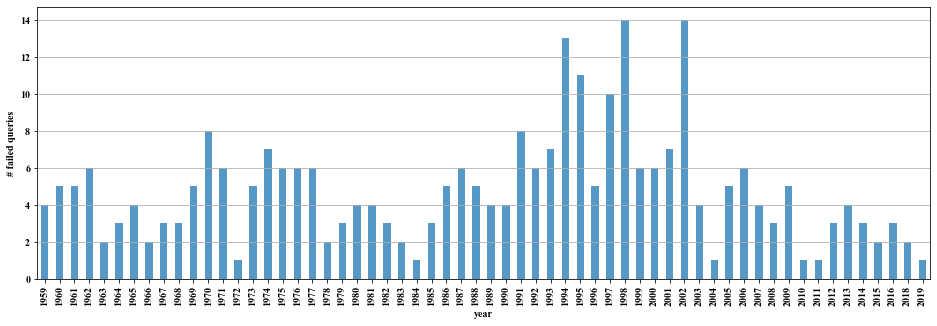

In [7]:
print('Unable to query {} songs for audio features'.format(len(failed)))

ax = failed.year\
           .value_counts()\
           .sort_index()\
           .plot.bar(figsize = (16,5), alpha=0.75)
ax.yaxis.grid(True)
ax.set(xlabel = 'year', ylabel = '# failed queries');

## Save Spotify data

In [8]:
df2.to_csv('../data/spotify.csv', index=False)

## Combine with Billboard and lyrics data
Finally, we combine all three data sources.

In [9]:
# df1 and df2 have different sizes because of unsuccessful queries
# therefore, we must merge on respective indices
billboard = pd.read_csv('../data/billboard-lyrics.csv')
df2 = pd.read_csv('../data/spotify.csv')
df1 = billboard.copy().drop(['index'], axis=1).reset_index()
df1['index'] = df1['index'].astype(float)
df_merge = pd.merge(df1, df2, how='left', left_on='index', right_on='billboard_df_index')

# billboard name and artist are copies of song and artist_base for verifying
# merge consistency and can be removed
column_mask = df_merge.columns.str.contains('billboard')
df_merge = df_merge.loc[:, ~column_mask]

# unnecessary to keep
df_merge = df_merge.drop(
    ['index', 'source', 'id', 'type', 'uri', 'spotify_artist',
     'spotify_song', 'spotify_album'], axis=1)

## Create derived features

In [10]:
# convert duration to more manageable units and drop original feature
df_merge['duration_min'] = df_merge['duration_ms'] / 1000 / 60
df_merge = df_merge.drop('duration_ms', axis=1)

# count number of words for each song
df_merge['num_words'] = df_merge['lyrics'].apply(
    lambda x: len(x.split()) if not isinstance(x, float) else np.nan)

# measure number of words per second for each song
df_merge['words_per_sec'] = df_merge['num_words'] /\
    (df_merge['duration_min'] * 60)

# count number of unique words for each song
df_merge['num_uniq_words'] = df_merge['lyrics'].apply(
    lambda x: pd.Series(
        x.split()).nunique() if not isinstance(x, float) else np.nan)

# convert years to decade for each song (but without dropping original feature)
df_merge['decade'] = df_merge['year'] // 10 * 10

# measure ratio of total words to unique words for each song
df_merge['uniq_ratio'] = df_merge['num_words'] / df_merge['num_uniq_words']
df_merge.tail()

<ipython-input-10-708b5d7fecfd>:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lambda x: pd.Series(


,rank,song,artist_base,artist_all,year,artist_featured,song_clean,artist_clean,lyrics,acousticness,...,speechiness,tempo,time_signature,valence,duration_min,num_words,words_per_sec,num_uniq_words,decade,uniq_ratio
6096,96,eyes on you,chase rice,chase rice,2019,NaN,eyes on you,chase rice,weve been to both carolinas seen a big montan...,0.323,...,0.0281,97.155,4.0,0.476,3.041550,317.0,1.737053,122.0,2010,2.598361
6097,97,all to myself,dan + shay,dan + shay,2019,NaN,all to myself,dan shay,NaN,0.230,...,0.0303,94.940,4.0,0.619,2.826867,NaN,NaN,NaN,2010,NaN
6098,98,boyfriend,ariana grande,ariana grande and social house,2019,NaN,boyfriend,ariana grande,im a motherfuckin train wreck i dont wanna be...,0.119,...,0.4610,190.097,4.0,0.702,3.101783,385.0,2.068702,114.0,2010,3.377193
6099,99,walk me home,pink,pink,2019,NaN,walk me home,pink,theres something in the way you roll your eye...,NaN,...,NaN,NaN,NaN,NaN,NaN,250.0,NaN,92.0,2010,2.717391
6100,100,robbery,juice wrld,juice wrld,2019,NaN,robbery,juice wrld,this shit funny i was like oof this hennessy ...,0.348,...,0.0442,79.993,4.0,0.543,4.008783,311.0,1.292994,132.0,2010,2.356061


## Final processing

In [11]:
# normalize artist name for beyonce
df_merge['artist_clean'] = df_merge['artist_clean'].replace('beyonce knowles', 'beyonce')

# remove duplicate songs
df_merge = df_merge.drop_duplicates(
    subset=['artist_clean', 'song_clean'], keep='first')

# strip whitespace at beginning and ends of artist columns
artist_cols = ['artist_base', 'artist_all', 'artist_featured', 'artist_clean']
df_merge[artist_cols] = df_merge[artist_cols].applymap(
    lambda x: x.strip() if not isinstance(x, float) else np.nan)
df_merge.shape

(5844, 30)

## Save combined data

In [12]:
df_merge.to_csv('../data/billboard-lyrics-spotify.csv', index=False)

In [13]:
df_merge['lyrics'].notnull().sum()

5436